In [1]:
import os
import numpy as np
import pydicom
from scipy import ndimage
import tqdm

high_res_path = '/run/media/trevor/Seagate Backup Plus Drive/trevor_overflow/femur_test_img/F01/'
patches_path = 'patches/'

high_res_voxel_size = 0.033
desired_voxel_size = 0.2
patch_size = 64
overlap_size = 32
# patch_size = 8
# overlap_size = 0


In [2]:
def get_sorted_dicom_files(path):
    dicom_files = [os.path.join(path, f) for f in os.listdir(path)]
    return sorted(dicom_files)


def load_dicom_block(dicom_files, start, end):
    dicom_slices = [pydicom.dcmread(f).pixel_array for f in dicom_files[start:end]]
    img = np.stack(dicom_slices, axis=-1)
    return img

def extract_patches(img, patch_id):
    downsampled_img = ndimage.zoom(img, high_res_voxel_size / desired_voxel_size)
    x_size, y_size, z_size = downsampled_img.shape
    if z_size < patch_size:
        print(f'z size is less than patch size: {z_size}')
        return patch_id
    else:
        downsampled_img = downsampled_img[:, :, :patch_size]

    for x in range(0, x_size, patch_size - overlap_size):
        for y in range(0, y_size, patch_size - overlap_size):
            if x + patch_size <= x_size and y + patch_size <= y_size:
                patch = downsampled_img[x:x+patch_size, y:y+patch_size, :]
                patch_filename = os.path.join(patches_path, f'{str(patch_id).zfill(8)}.npy')
                np.save(patch_filename, patch)
                patch_id += 1
    
    return patch_id

    

In [3]:
high_res_files = get_sorted_dicom_files(high_res_path)
high_res_patch_size = int (patch_size * desired_voxel_size / high_res_voxel_size + 1)
high_res_overlap_size = int (overlap_size * desired_voxel_size / high_res_voxel_size + 1)
patch_id = 0

for i in tqdm.tqdm(range(0, len(high_res_files), high_res_patch_size - high_res_overlap_size)):
    print(i)
    if i + high_res_patch_size <= len(high_res_files):
        img = load_dicom_block(high_res_files, i, i + high_res_patch_size)
        patch_id = extract_patches(img, patch_id)
        print(f'Processed {i} of {len(high_res_files)}')


  0%|                                                                                                                                                                                                                                                  | 0/19 [00:00<?, ?it/s]

0
downsampled_img (383, 383, 64)
hi2
patches/00000000.npy
hi2
patches/00000001.npy
hi2
patches/00000002.npy
hi2
patches/00000003.npy
hi2
patches/00000004.npy
hi2
patches/00000005.npy
hi2
patches/00000006.npy
hi2
patches/00000007.npy
hi2
patches/00000008.npy
hi2
patches/00000009.npy
hi2
hi2
hi2
patches/00000010.npy
hi2
patches/00000011.npy
hi2
patches/00000012.npy
hi2
patches/00000013.npy
hi2
patches/00000014.npy
hi2
patches/00000015.npy
hi2
patches/00000016.npy
hi2
patches/00000017.npy
hi2
patches/00000018.npy
hi2
patches/00000019.npy
hi2
hi2
hi2
patches/00000020.npy
hi2
patches/00000021.npy
hi2
patches/00000022.npy
hi2
patches/00000023.npy
hi2
patches/00000024.npy
hi2
patches/00000025.npy
hi2
patches/00000026.npy
hi2
patches/00000027.npy
hi2
patches/00000028.npy
hi2
patches/00000029.npy
hi2
hi2
hi2
patches/00000030.npy
hi2
patches/00000031.npy
hi2
patches/00000032.npy
hi2
patches/00000033.npy
hi2
patches/00000034.npy
hi2
patches/00000035.npy
hi2
patches/00000036.npy
hi2
patches/000000

  5%|████████████▎                                                                                                                                                                                                                            | 1/19 [02:14<40:23, 134.63s/it]

patches/00000069.npy
hi2
hi2
hi2
patches/00000070.npy
hi2
patches/00000071.npy
hi2
patches/00000072.npy
hi2
patches/00000073.npy
hi2
patches/00000074.npy
hi2
patches/00000075.npy
hi2
patches/00000076.npy
hi2
patches/00000077.npy
hi2
patches/00000078.npy
hi2
patches/00000079.npy
hi2
hi2
hi2
patches/00000080.npy
hi2
patches/00000081.npy
hi2
patches/00000082.npy
hi2
patches/00000083.npy
hi2
patches/00000084.npy
hi2
patches/00000085.npy
hi2
patches/00000086.npy
hi2
patches/00000087.npy
hi2
patches/00000088.npy
hi2
patches/00000089.npy
hi2
hi2
hi2
patches/00000090.npy
hi2
patches/00000091.npy
hi2
patches/00000092.npy
hi2
patches/00000093.npy
hi2
patches/00000094.npy
hi2
patches/00000095.npy
hi2
patches/00000096.npy
hi2
patches/00000097.npy
hi2
patches/00000098.npy
hi2
patches/00000099.npy
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
100
Processed 0 of 3500
194
downsampled_img (383, 383, 64)
hi2
patches/00000100.npy
hi2
patches/00000

 11%|████████████████████████▌                                                                                                                                                                                                                | 2/19 [04:05<34:11, 120.69s/it]

patches/00000171.npy
hi2
patches/00000172.npy
hi2
patches/00000173.npy
hi2
patches/00000174.npy
hi2
patches/00000175.npy
hi2
patches/00000176.npy
hi2
patches/00000177.npy
hi2
patches/00000178.npy
hi2
patches/00000179.npy
hi2
hi2
hi2
patches/00000180.npy
hi2
patches/00000181.npy
hi2
patches/00000182.npy
hi2
patches/00000183.npy
hi2
patches/00000184.npy
hi2
patches/00000185.npy
hi2
patches/00000186.npy
hi2
patches/00000187.npy
hi2
patches/00000188.npy
hi2
patches/00000189.npy
hi2
hi2
hi2
patches/00000190.npy
hi2
patches/00000191.npy
hi2
patches/00000192.npy
hi2
patches/00000193.npy
hi2
patches/00000194.npy
hi2
patches/00000195.npy
hi2
patches/00000196.npy
hi2
patches/00000197.npy
hi2
patches/00000198.npy
hi2
patches/00000199.npy
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
hi2
200
Processed 194 of 3500
388


 11%|████████████████████████▌                                                                                                                                                                                                                | 2/19 [04:18<36:35, 129.17s/it]


KeyboardInterrupt: 

In [89]:
test = np.load('patches/00000147.npy')

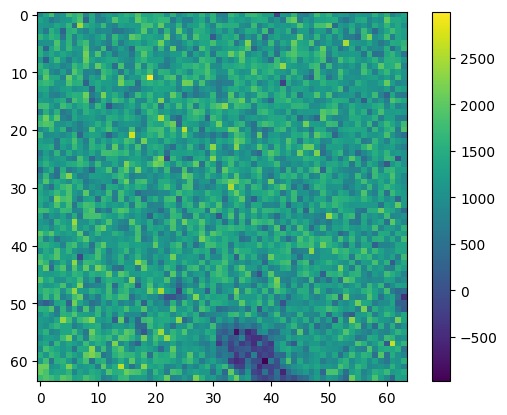

In [90]:
import matplotlib.pyplot as plt

plt.imshow(test[:,:,32])
plt.colorbar()

In [88]:
test_img = pydicom.dcmread('/run/media/trevor/Seagate Backup Plus Drive/trevor_overflow/femur_test_img/F01/C0008408_1_00063.DCM').pixel_array

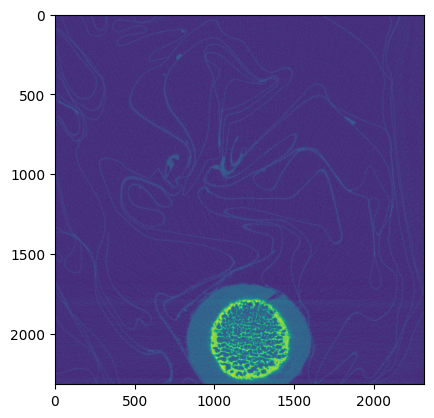

In [86]:
plt.imshow(test_img)